In [1]:
import torch
from transformers import LlamaForCausalLM, AutoTokenizer
from datasets import load_dataset
import numpy as np
from scipy.spatial.distance import pdist, squareform
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from copy import deepcopy

device = "cuda:0"

# 1. Инициализация модели и токенизатора
model = LlamaForCausalLM.from_pretrained(
    "unsloth/Llama-3.2-3B-Instruct",
    torch_dtype=torch.float16,
    device_map=device
)
model.eval()
tokenizer = AutoTokenizer.from_pretrained("unsloth/Llama-3.2-3B-Instruct")

# 2. Подготовка 20 образцов MMLU (dev)
ds = load_dataset("cais/mmlu", "all",split="dev")
smpl = ds.shuffle(seed=42).select(range(20))
texts = [
    item["question"] + " Варианты: " + " ".join(item["choices"])
    for item in smpl
]
inputs = tokenizer(
    texts,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=128
)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [2]:
inputs['input_ids'] = inputs['input_ids'].to(device)
inputs['attention_mask'] = inputs['attention_mask'].to(device)

In [3]:
# Собираем скрытые состояния до каждого слоя
with torch.no_grad():
    out = model(**inputs, output_hidden_states=True)
hidden_states = out.hidden_states  # список длины num_layers+1

In [4]:
len(hidden_states), hidden_states[0].shape

(29, torch.Size([20, 100, 3072]))

In [5]:
model


LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(128256, 3072, padding_idx=128004)
    (layers): ModuleList(
      (0-27): 28 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
          (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
          (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
   

In [6]:
inputs = {k: v.to(model.device) for k, v in inputs.items()}
inputs['attention_mask'] = torch.tril(torch.ones(100, 100, dtype=bool, device=device))

num_layers = model.config.num_hidden_layers
num_heads = model.config.num_attention_heads
head_dim = model.config.hidden_size // num_heads
layer_idx = num_layers // 2  # средний слой

In [7]:
position_ids = torch.arange(
    0, 100, dtype = torch.long, device = device
)

position_embeddings = model.model.rotary_emb(inputs['input_ids'], position_ids[None, :])

In [8]:
model.model.layers[0]

LlamaDecoderLayer(
  (self_attn): LlamaSdpaAttention(
    (q_proj): Linear(in_features=3072, out_features=3072, bias=False)
    (k_proj): Linear(in_features=3072, out_features=1024, bias=False)
    (v_proj): Linear(in_features=3072, out_features=1024, bias=False)
    (o_proj): Linear(in_features=3072, out_features=3072, bias=False)
    (rotary_emb): LlamaRotaryEmbedding()
  )
  (mlp): LlamaMLP(
    (gate_proj): Linear(in_features=3072, out_features=8192, bias=False)
    (up_proj): Linear(in_features=3072, out_features=8192, bias=False)
    (down_proj): Linear(in_features=8192, out_features=3072, bias=False)
    (act_fn): SiLU()
  )
  (input_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
  (post_attention_layernorm): LlamaRMSNorm((3072,), eps=1e-05)
)

In [9]:
def extract_head_repr_forward(layer_idx, head_idx, position_embeddings, hidden_states, inputs, model):
    """
    Извлекаем представление заданной головы через forward self-attn одного слоя.
    
    Args:
        layer_idx: Индекс слоя
        head_idx: Индекс головы
        position_embeddings: Позиционные эмбеддинги
        hidden_states: Скрытые состояния модели
        inputs: Входные данные (содержит attention_mask)
        model: Модель трансформера
    
    Returns:
        Векторное представление головы [hidden_size]
    """
    # Получаем модуль слоя
    layer = model.model.layers[layer_idx]
    # inp = hidden_states[layer_idx][None, ...]  # [batch, seq, hidden_size]
    inp = hidden_states
    
    # Сохраняем оригинальные веса
    orig_q_weight = layer.self_attn.q_proj.weight.data.clone()
    orig_k_weight = layer.self_attn.k_proj.weight.data.clone()
    orig_v_weight = layer.self_attn.v_proj.weight.data.clone()

    try:
        with torch.no_grad():
            hidden_dim_q = layer.self_attn.q_proj.weight.shape[-2]
            hidden_dim_kv = layer.self_attn.k_proj.weight.shape[-2]
            num_heads = 24
            head_dim = 128

            # Создаем маску для выбранной головы
            mask_q = torch.zeros((num_heads, hidden_dim_q), device= model.device)
            mask_kv = torch.zeros((num_heads, hidden_dim_kv), device= model.device)
            mask_q[head_idx] = 1.0  
            mask_kv[head_idx] = 1.0  

            # Применяем маски к проекционным матрицам
            q_mask = mask_q.repeat_interleave(head_dim, dim=0)
            layer.self_attn.q_proj.weight.data *= q_mask.T
            
            k_mask = mask_kv.repeat_interleave(head_dim, dim=0)
            v_mask = mask_kv.repeat_interleave(head_dim, dim=0)

            layer.self_attn.k_proj.weight.data *= k_mask.T
            layer.self_attn.v_proj.weight.data *= v_mask.T

            # Forward pass через self-attention
            attn_out = layer.self_attn(
                inp,
                attention_mask=inputs.get("attention_mask")[None, None, :, :], 
                position_embeddings=position_embeddings, 
            )[0]

            # Усредняем по батчу и последовательности
            rep = attn_out.mean(dim=(0,1))  # [hidden_size]
            
    finally:
        # Восстанавливаем оригинальные веса
        layer.self_attn.q_proj.weight.data.copy_(orig_q_weight)
        layer.self_attn.k_proj.weight.data.copy_(orig_k_weight)
        layer.self_attn.v_proj.weight.data.copy_(orig_v_weight)

    return rep.detach().cpu().numpy()

In [10]:
num_heads

24

In [11]:
import inspect

print(inspect.getsource(type(model.model.layers[0].self_attn)))

class LlamaSdpaAttention(LlamaAttention):
    """
    Llama attention module using torch.nn.functional.scaled_dot_product_attention. This module inherits from
    `LlamaAttention` as the weights of the module stays untouched. The only changes are on the forward pass to adapt to
    SDPA API.
    """

    # Adapted from LlamaAttention.forward
    def forward(
        self,
        hidden_states: torch.Tensor,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        past_key_value: Optional[Cache] = None,
        output_attentions: bool = False,
        use_cache: bool = False,
        cache_position: Optional[torch.LongTensor] = None,
        position_embeddings: Optional[Tuple[torch.Tensor, torch.Tensor]] = None,  # will become mandatory in v4.46
        **kwargs,
    ) -> Tuple[torch.Tensor, Optional[torch.Tensor], Optional[Tuple[torch.Tensor]]]:
        if output_attentions:
            # TODO: Improve this warning with e

In [12]:
# Выбираем слои для анализа (первый, средние и последние)
num_layers = model.config.num_hidden_layers
layers = [0, num_layers//2-1, num_layers//2, num_layers-2, num_layers-1]
layer_reprs = {}

for li in layers:
    # Подготавливаем скрытые состояния для текущего слоя
    hidden_state_for_layer = hidden_states[li].to(model.device)
    
    # Извлекаем представления всех голов для этого слоя
    reps = np.stack([
        extract_head_repr_forward(
            layer_idx=li,
            head_idx=h,
            position_embeddings=position_embeddings,
            hidden_states=hidden_state_for_layer,
            inputs=inputs,
            model=model
        )
        for h in range(num_heads)
    ], axis=0)
    
    layer_reprs[li] = reps
    print(f"Layer {li} representations shape:", reps.shape)

Layer 0 representations shape: (24, 3072)
Layer 13 representations shape: (24, 3072)
Layer 14 representations shape: (24, 3072)
Layer 26 representations shape: (24, 3072)
Layer 27 representations shape: (24, 3072)


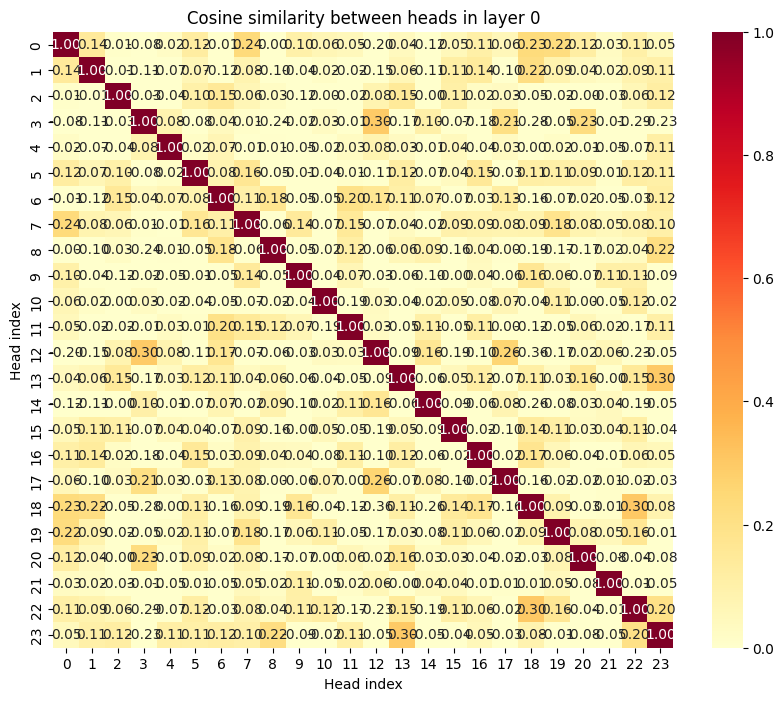


Layer 0 - No similar heads found (threshold: 0.5)


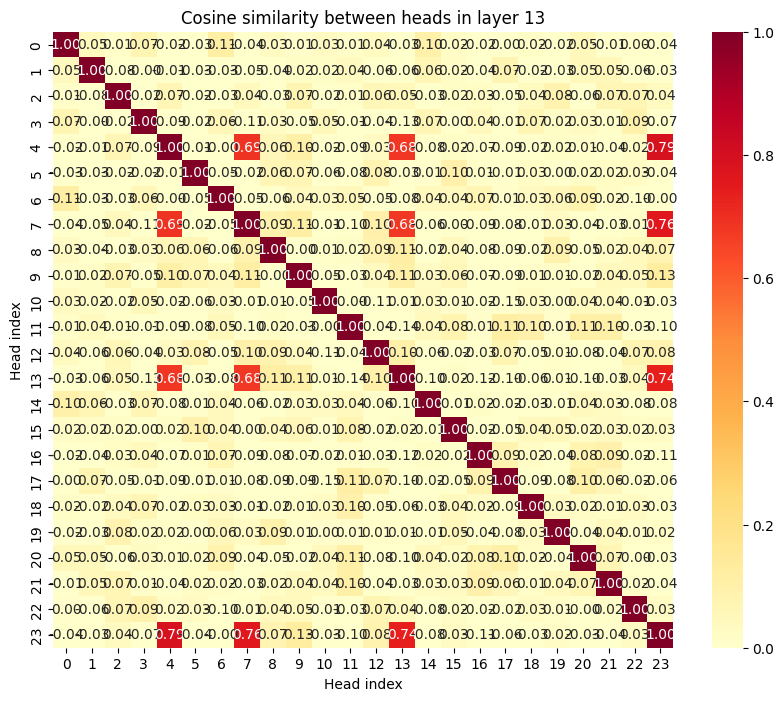


Layer 13 - Found 6 pairs with cos_sim >= 0.5:
Heads 4 and 23 - similarity: 0.788
Heads 7 and 23 - similarity: 0.758
Heads 13 and 23 - similarity: 0.736
Heads 4 and 7 - similarity: 0.688
Heads 4 and 13 - similarity: 0.683
Heads 7 and 13 - similarity: 0.679


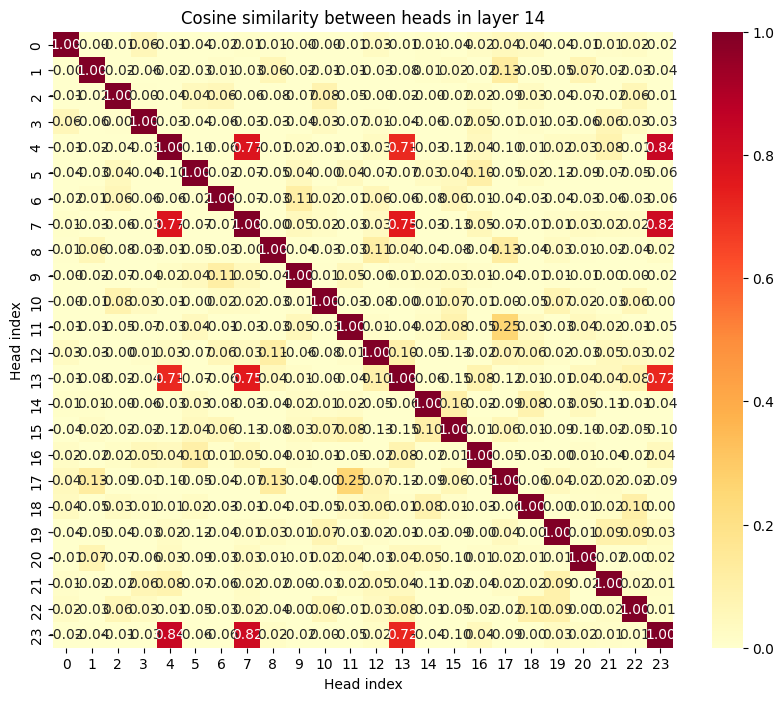


Layer 14 - Found 6 pairs with cos_sim >= 0.5:
Heads 4 and 23 - similarity: 0.841
Heads 7 and 23 - similarity: 0.822
Heads 4 and 7 - similarity: 0.774
Heads 7 and 13 - similarity: 0.751
Heads 13 and 23 - similarity: 0.719
Heads 4 and 13 - similarity: 0.711


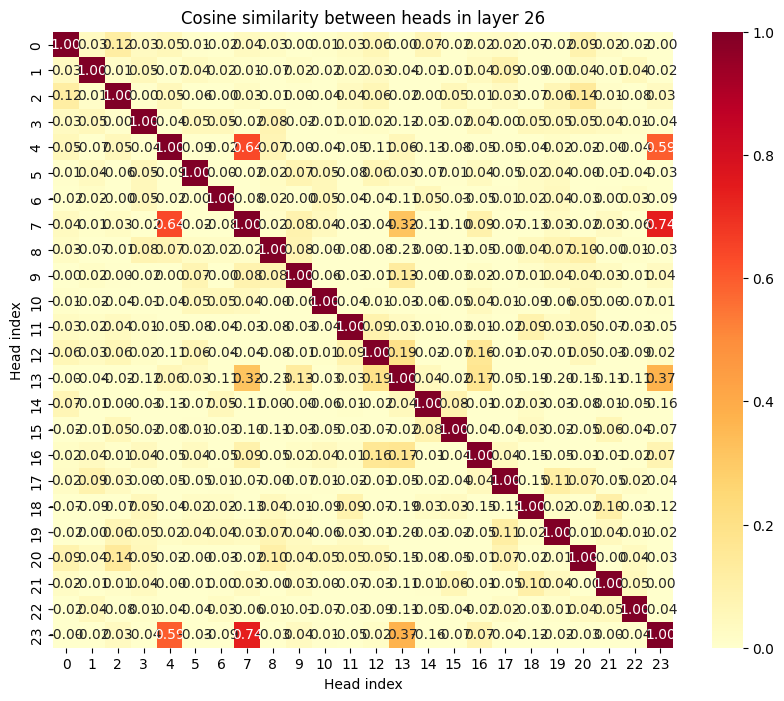


Layer 26 - Found 3 pairs with cos_sim >= 0.5:
Heads 7 and 23 - similarity: 0.739
Heads 4 and 7 - similarity: 0.638
Heads 4 and 23 - similarity: 0.594


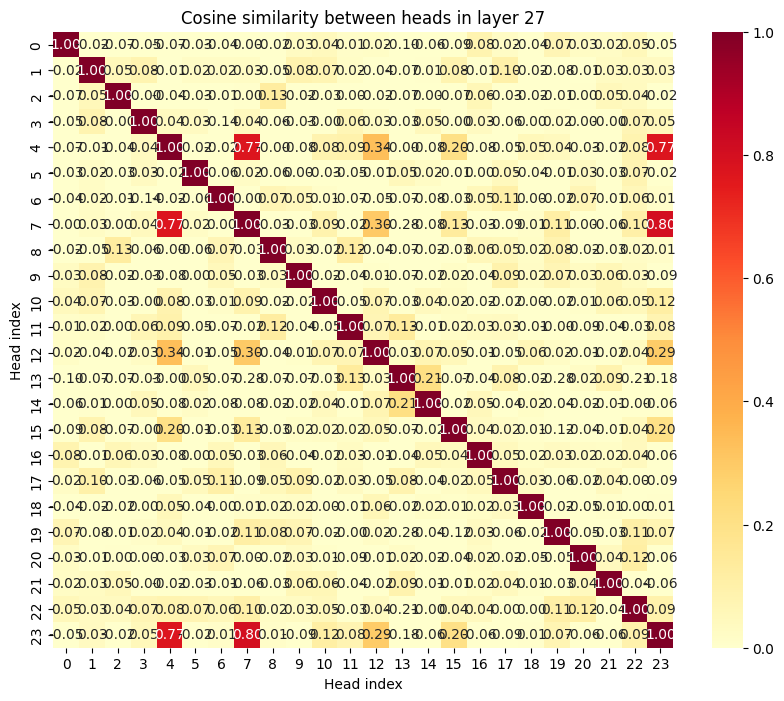


Layer 27 - Found 3 pairs with cos_sim >= 0.5:
Heads 7 and 23 - similarity: 0.804
Heads 4 and 7 - similarity: 0.772
Heads 4 and 23 - similarity: 0.772


In [13]:

# Теперь можно анализировать сходство между головами в каждом слое
for li, reprs in layer_reprs.items():
    # Вычисляем косинусное сходство
    # Use torch for numerically stable cosine similarity computation
    reprs_t = torch.from_numpy(reprs)
    reprs_t = reprs_t.float()  # ensure float32 for precision
    reprs_t = reprs_t / reprs_t.norm(dim=1, keepdim=True).clamp(min=1e-8)
    cos_sim = (reprs_t @ reprs_t.T).cpu().numpy()
    
    # Визуализация
    plt.figure(figsize=(10, 8))
    sns.heatmap(cos_sim, annot=True, fmt=".2f", cmap="YlOrRd", vmin=0, vmax=1)
    plt.title(f"Cosine similarity between heads in layer {li}")
    plt.xlabel("Head index")
    plt.ylabel("Head index")
    plt.show()
    
    # Находим наиболее похожие пары голов
    threshold = 0.5  # Порог сходства
    pairs = []
    for i in range(num_heads):
        for j in range(i+1, num_heads):
            if cos_sim[i,j] >= threshold:
                pairs.append((i, j, float(cos_sim[i,j])))
    
    if pairs:
        print(f"\nLayer {li} - Found {len(pairs)} pairs with cos_sim >= {threshold}:")
        for pair in sorted(pairs, key=lambda x: -x[2]):
            print(f"Heads {pair[0]} and {pair[1]} - similarity: {pair[2]:.3f}")
    else:
        print(f"\nLayer {li} - No similar heads found (threshold: {threshold})")